# Custom sampler

I was curious how I could train the model with different batches for the various #s of jets, and it seemed like this [class](https://discuss.pytorch.org/t/tensorflow-esque-bucket-by-sequence-length/41284) did *exactly* what I wanted!

In [1]:
import numpy as np

import torch
from torch.utils.data import Dataset,DataLoader,ConcatDataset
from torch.utils.data import Sampler,SubsetRandomSampler
import matplotlib.pyplot as plt

import os
os.sys.path.append('../pairAGraphTraining/')
from prepareData import getGNNDataLoaders

%load_ext autoreload
%autoreload 2

In [24]:
N = 1000

In [25]:
X0 = torch.cat([normal(0.,1.,(N,1)) for i in range(2)],axis=1)
X1 = torch.cat([normal(2.,1.,(N,1)) for i in range(2)],axis=1)

(-3.0, 5.0)

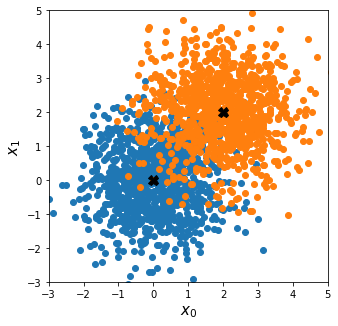

In [37]:
plt.figure(figsize=(5,5))
plt.scatter(*X0.T)
plt.scatter(*X1.T)
plt.xlabel('$x_0$',fontsize=15)
plt.ylabel('$x_1$',fontsize=15)

plt.plot([0],[0],'k',marker='X',markersize=10)
plt.plot([2],[2],'k',marker='X',markersize=10)
#plt.scatter(*X1.T)

plt.xlim(-3,5)
plt.ylim(-3,5)

Ok, let's combine them in a single dataset, and maybe just keep track of the 

In [106]:
class testDataset(Dataset):
    def __init__(self, mus=[0.,2.], Ns=[100,150]):
        
        std = 1.
        
        Xs = [torch.cat([torch.normal(mu,std,(N,1)) for i in range(2)], axis=1) 
              for mu,N in zip(mus,Ns) ]
        
        ys = [ i * torch.ones(N) for i,N in enumerate(Ns)]
        
        self.X = torch.cat(Xs,axis=0)
        self.y = torch.cat(ys,axis=0)
        
        self.Ns = Ns
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [107]:
dset = testDataset()

In [125]:
dset[1]

(tensor([-1.2228,  2.9732]), tensor(0.))

In [129]:
class byExsSampler(Sampler):
    '''
    Custom sampler which samples batches based on the # of jets.
    '''
    
    def __init__(self, dset, batch_size=50):
        
        self.dset = dset
        self.Ns = dset.Ns    
        self.batch_size = batch_size
    
        
    def __iter__(self):
  
        Ns, mb = self.Ns, self.batch_size

        # Combining
        idx_lists = [] 
        
        dset_bounds = [0] + list(np.add.accumulate(Ns)) # Maybe this can go in init?
        for i_min, i_max, N in zip(dset_bounds[:-1], dset_bounds[1:], self.Ns):
            
            idx_c = torch.arange(i_min,i_max) # indices for this class 
            r = torch.randperm(N) # shuffle for this class 
            bs = np.arange(0,N+1,mb) # boundaries for the mini-batches for this class

            list_c = [ idx_c[r[j_min:j_max]] for j_min, j_max in zip(bs[:-1],bs[1:])]
            idx_lists += list_c        
        
        # And now randomizing over the class
        num_batches = len(idx_lists)

        # Randomly order the mini-batches
        mb_random = torch.randperm(num_batches)

        # Now the part that returns the batches!
        for mbi in mb_random:
            yield idx_lists[mbi]
    
    
    def __len__(self):
        # I *think* I want this to be # of batches - I might need to check tho.
        return (len(self.dset) + self.batch_size - 1)// self.batch_size
    

In [131]:
stest = byExsSampler(dset)
di = DataLoader(dset,batch_sampler=stest)

for i,(xi,yi) in enumerate(di):
    print(i,xi.shape,yi.shape)
    print('  ',xi[0],yi[0])

0 torch.Size([50, 2]) torch.Size([50])
   tensor([3.0081, 1.5732]) tensor(1.)
1 torch.Size([50, 2]) torch.Size([50])
   tensor([ 0.4879, -0.0426]) tensor(0.)
2 torch.Size([50, 2]) torch.Size([50])
   tensor([-0.6451, -0.0416]) tensor(0.)
3 torch.Size([50, 2]) torch.Size([50])
   tensor([3.7330, 0.9370]) tensor(1.)
4 torch.Size([50, 2]) torch.Size([50])
   tensor([2.9439, 1.7285]) tensor(1.)


**Sweet** Ok, now I have most of it, except my X tensors will have different lengths rn.

In [136]:
dset2 = testDataset()

In [142]:
class varyDims(Dataset):
    def __init__(self, mu=0., N=100, dim=2):
        
        std = 1.
        
        self.X = torch.cat([torch.normal(mu,std,(N,1)) for i in range(dim)],axis=1)
        self.y = (dim-1) * torch.ones(N)
        
        self.N = N
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [147]:
d1 = varyDims(mu=0,dim=1)
d2 = varyDims(mu=2,dim=2)
d3 = varyDims(mu=10,dim=3)

In [148]:
d1[0]

(tensor([-0.1247]), tensor(0.))

In [149]:
d2[0]

(tensor([2.2532, 3.2598]), tensor(1.))

In [150]:
d3[0]

(tensor([10.3046, 10.3628, 11.3315]), tensor(2.))

In [151]:
cd = ConcatDataset([d1,d2,d3])

In [152]:
len(cd)

300

In [156]:
cd[200]

(tensor([10.3046, 10.3628, 11.3315]), tensor(2.))

In [160]:
class varyDimsSampler(Sampler):
    '''
    Custom sampler which samples batches based on the # of jets.
    '''
    
    def __init__(self, dset, Ns, batch_size=50):
        '''
        Inputs:
        - dset: An instance of a ConcatDataset
        - Ns: List of the length of the individual subdatasets inside the dset
        - batch_size: mini-batch size to use for each of the classes
        '''
        
        self.dset = dset
        self.Ns = Ns
        self.batch_size = batch_size
    
        # Take the length of the individual datasets + calculate sample boundaries
        self.dset_bounds = [0] + list(np.add.accumulate(Ns))
        
        
    def __iter__(self):
  
        Ns, mb, dset_bounds = self.Ns, self.batch_size, self.dset_bounds

    
        # Get a list of the batches
        idx_lists = [] 
        for i_min, i_max, N in zip(dset_bounds[:-1], dset_bounds[1:], self.Ns):
            
            idx_c = torch.arange(i_min,i_max) # indices for this class 
            r = torch.randperm(N) # shuffle for this class 
            bs = np.arange(0,N+1,mb) # boundaries for the mini-batches for this class

            list_c = [ idx_c[r[j_min:j_max]] for j_min, j_max in zip(bs[:-1],bs[1:])]
            idx_lists += list_c        
        
        # Randomly order the mini-batches
        num_batches = len(idx_lists)
        mb_random = torch.randperm(num_batches)

        # Now the part that returns the batches!
        for mbi in mb_random:
            yield idx_lists[mbi]
    
    
    def __len__(self):
        # number of mini-batches 
        return sum([(N + self.batch_size - 1)// self.batch_size for N in self.Ns])
    

In [163]:
s = varyDimsSampler(cd, [100]*3)
dl = DataLoader(cd,batch_sampler=s)

for i,(xi,yi) in enumerate(dl):
    print(i,xi.shape,yi.max(),yi.min())

0 torch.Size([50, 3]) tensor(2.) tensor(2.)
1 torch.Size([50, 2]) tensor(1.) tensor(1.)
2 torch.Size([50, 2]) tensor(1.) tensor(1.)
3 torch.Size([50, 1]) tensor(0.) tensor(0.)
4 torch.Size([50, 1]) tensor(0.) tensor(0.)
5 torch.Size([50, 3]) tensor(2.) tensor(2.)


In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame(np.ones((5,3)))

In [11]:
torch.tensor(df[0])

tensor([1., 1., 1., 1., 1.], dtype=torch.float64)

In [24]:
loader_tr, loader_val = getGNNDataLoaders()

Getting pagDataset for 2b, holding out fold 1/2
155937  train + val events
Getting pagDataset for 2b, holding out fold 1/2
132069  train + val events


In [23]:
for x in loader_tr:
    break

124749
256
105655
256


In [25]:
124749//256, 

487

In [28]:
105655//256

412

In [27]:
len(loader_tr)

901

In [29]:
487+412

899